In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut, RepeatedKFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler # robust_scale
from sklearn.svm import SVR

In [2]:
raw = pd.read_csv('../data/training_final_latcorr.csv')

In [6]:
raw.columns

Index(['field_1', 'Name', 'Longitude', 'Latitude', 'CO2 (mg C m¯² d¯¹)',
       'CH4 (mg C m-2 d-1)', 'CO2 (g/kWh)', 'CH4 (g/kWh)',
       'Area / Electricity', 'Area_km2', 'Age', 'Volume_km3',
       'Areakm2_div_Volkm3', 'org_c', 'temp_annual_avg',
       'temp_diff_summer_winter_lc', 'temp_spring_avg_lc', 'temp_spring_avg',
       'temp_summer_avg_lc', 'temp_summer_avg', 'temp_fall_avg_lc',
       'temp_fall_avg', 'temp_winter_avg_lc', 'temp_winter_avg',
       'NDVI_annual_avg', 'NDVI_spring_avg_lc', 'NDVI_spring_avg',
       'NDVI_summer_avg_lc', 'NDVI_summer_avg', 'NDVI_fall_avg_lc',
       'NDVI_fall_avg', 'NDVI_winter_avg_lc', 'NDVI_winter_avg',
       'npp_annual_avg', 'npp_spring_avg_lc', 'npp_spring_avg',
       'npp_summer_avg_lc', 'npp_summer_avg', 'npp_fall_avg_lc',
       'npp_fall_avg', 'npp_winter_avg_lc', 'npp_winter_avg', 'erosion',
       'precip'],
      dtype='object')

In [11]:
ch4_raw_cols = [
    'CH4 (mg C m-2 d-1)',
    'Age', 
    'org_c', 
    'temp_annual_avg',
    'temp_diff_summer_winter_lc', 
    'NDVI_annual_avg', 
    'npp_annual_avg', 
    'erosion',
    'precip'
]

clean = raw[ch4_raw_cols].copy()

print("raw.shape   =", raw.shape)
print("clean.shape =", clean.shape)

raw.shape   = (154, 44)
clean.shape = (154, 9)


In [12]:
clean['log_ch4_emissions'] = np.log(clean['CH4 (mg C m-2 d-1)'])


In [13]:
reduced = clean.dropna()
reduced.shape

(95, 10)

In [14]:
#target = 'CH4 (mg C m¯² d¯¹)'
target = 'log_ch4_emissions'

features = ['Age', 'org_c', 'temp_annual_avg', 'temp_diff_summer_winter_lc', 
            'NDVI_annual_avg', 'npp_annual_avg', 'erosion', 'precip']

X = reduced[features]
y = reduced[target]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [16]:
print("X_train.shape =", X_train.shape)
print("X_test.shape  =", X_test.shape)
print("y_train.shape =", y_train.shape)
print("y_test.shape  =", y_test.shape)

X_train.shape = (71, 8)
X_test.shape  = (24, 8)
y_train.shape = (71,)
y_test.shape  = (24,)


In [17]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knr', KNeighborsRegressor())
])

pipeline.fit(X_train, y_train)

print("Train score =", pipeline.score(X_train, y_train))
print("Test score  =", pipeline.score(X_test, y_test))

Train score = 0.6610158759069833
Test score  = 0.5939219215382908


In [18]:
parameters = {
    'knr__n_neighbors': range(1, round(len(y_train) / 2)),
    'knr__weights': ['uniform', 'distance']
}

my_cv = RepeatedKFold(n_splits=2, n_repeats=10, random_state=0)

best_ch4_model = GridSearchCV(pipeline, parameters, cv=my_cv, n_jobs=-1, scoring='r2') 

best_ch4_model.fit(X_train, y_train)

print("Best score: %0.3f" % best_ch4_model.best_score_)
best_parameters = best_ch4_model.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

best_ch4_model.best_estimator_.score(X_test, y_test)

Best score: 0.408
	knr__n_neighbors: 7
	knr__weights: 'distance'


0.5745620297066754

## Use this model to predict CO2 emissions in USA dataset

In [23]:
present = pd.read_csv('../data_predict/merged_PRESENT.csv')
best_case = pd.read_csv('../data_predict/merged_2100ssp126.csv')
worst_case = pd.read_csv('../data_predict/merged_2100ssp585.csv')

In [24]:
for column in present[features]:
    print(column, ':',  present[features][column].isna().sum())

Age : 0
org_c : 0
temp_annual_avg : 0
temp_diff_summer_winter_lc : 0
NDVI_annual_avg : 0
npp_annual_avg : 33
erosion : 0
precip : 0


In [25]:
present['npp_annual_avg'] = present['npp_annual_avg'].fillna(present['npp_annual_avg'].mean())
best_case['npp_annual_avg'] = best_case['npp_annual_avg'].fillna(best_case['npp_annual_avg'].mean())
worst_case['npp_annual_avg'] = worst_case['npp_annual_avg'].fillna(worst_case['npp_annual_avg'].mean())

In [230]:
# present = present[features].dropna()
# best_case = best_case[features].dropna()
# worst_case = worst_case[features].dropna()

In [232]:
##WRONG!
# present['co2_emissions'] = 10**present['co2_emissions_logscale']
# best_case['co2_emissions'] = 10**best_case['co2_emissions_logscale']
# worst_case['co2_emissions'] = 10**worst_case['co2_emissions_logscale']

In [234]:
# np.exp(np.log(9))

9.000000000000002

In [235]:
# 10**np.log10(9)

9.0

In [237]:
# np.exp(1)

2.718281828459045

In [26]:
present['ch4_emissions_logscale'] = best_ch4_model.best_estimator_.predict(present[features])
best_case['ch4_emissions_logscale'] = best_ch4_model.best_estimator_.predict(best_case[features])
worst_case['ch4_emissions_logscale'] = best_ch4_model.best_estimator_.predict(worst_case[features])

In [27]:
present['ch4_emissions'] = np.exp(present['ch4_emissions_logscale'])
best_case['ch4_emissions'] = np.exp(best_case['ch4_emissions_logscale'])
worst_case['ch4_emissions'] = np.exp(worst_case['ch4_emissions_logscale'])

In [28]:
present.to_csv('../data_predict/merged_PRESENT_ch4predicted.csv')
best_case.to_csv('../data_predict/merged_2100ssp126_ch4predicted.csv')
worst_case.to_csv('../data_predict/merged_2100ssp585_ch4predicted.csv')

In [29]:
present['ch4_emissions'].median()

8.630448002073233

In [30]:
best_case['ch4_emissions'].median()

9.868341480242194

In [31]:
worst_case['ch4_emissions'].median()

11.969202162451115

In [ ]:
#plotting results

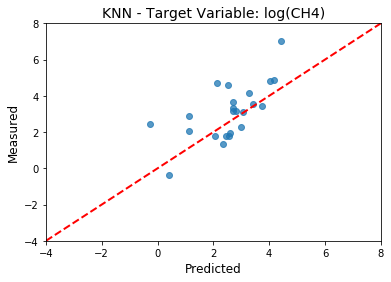

In [36]:
y_pred = best_ch4_model.predict(X_test)
y_true = y_test

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x=y_pred, y=y_true, alpha=.75)
ax.set_title('KNN - Target Variable: log(CH4)' , fontsize=14)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Measured', fontsize=12)
ax.set_sxlim([-4, 8])
ax.set_ylim([-4, 8])
ax.plot([-4,8], [-4, 8], color='red', linestyle='--', linewidth=2)
plt.savefig('knn_pred_vs_mes.png')

In [187]:
X.describe() - present[features].describe()

,Age,org_c,temp_annual_avg,temp_diff_summer_winter_lc,NDVI_annual_avg,npp_annual_avg,erosion,precip
count,-390.000000,-390.000000,-390.000000,-390.000000,-390.000000,-390.000000,-390.000000,-390.000000
mean,-39.039706,22.495782,-0.737727,-3.490620,11.403309,-4.631652,1.666287,160.791667
std,0.992507,-13.231013,6.257394,7.756561,9.379276,5.123202,0.932265,69.872036
min,-22.000000,5.547675,-3.655000,-8.226666,48.499996,15.000000,-0.002967,205.000000
25%,-38.250000,22.695223,-5.741417,-13.644334,-3.458336,-11.604170,-0.067599,83.500000
50%,-44.500000,26.661419,-5.520166,0.238667,-5.375000,-9.833328,-0.267902,95.000000
75%,-45.750000,28.360537,7.267668,5.193667,32.562500,-4.479168,-0.459402,176.000000
max,-75.000000,-432.466659,3.048000,2.828000,0.000000,-54.500000,-44.840134,157.000000


In [35]:
clean['CO2 (mg C m¯² d¯¹)'].describe()

KeyError: 'CO2 (mg C m¯² d¯¹)'

In [217]:
present['co2_emissions'].describe()

count    5.100000e+02
mean     3.528688e+05
std      5.851329e+05
min      2.573019e+03
25%      3.892283e+04
50%      1.487217e+05
75%      3.824149e+05
max      4.194479e+06
Name: co2_emissions, dtype: float64